# Employee Attrition Prediction Model

The model uses Employee Attrition dataset from Kaggle's and compares the effectiveness between using Logistic Regression, Neural Network, and Random Forest. We start by analyzing the dataset, keeping the significant ones and removing the uncorrelated ones to optimize performance from our models. Then we proceed to parsing, splitting, and normalizing before training our models. Below are explanations to our work and our code.

In [1]:
import pandas as pd

## Data Parsing

We start with all the data given from the dataset. The raw dataset has 1470 rows and 35 features including Attrition, which is our desired output feature. In terms of data types, there are 26 numerical features and 9 categorical features, ranging from 2 to 6 categories each.

Because we are working with employee attrition rate, there is a significant imbalance in our data. Roughly 83% of the data answered 'no' in attrition. This is our main challenge in developing the model. We need to use what we learned to account for the biased dataset. As an overview, we used SMOTE to oversample the minority class, and used ROC AUC as our main evaluation of the models robustness.

The Parse function below takes in a .CSV file, and does the following things:
1. drop the constant features (columns_to_drop_1)
2. drop the redundant features (columns_to_drop_2)
3. split into input and output features
4. One-hot encode the categorical columns
5. Map the 'Attrition' feature into boolean values

In [4]:
def parse_csv(file_path):
    """
    Parses the CSV file, normalizes numerical data, and one-hot encodes categorical variables.

    Parameters:
    - file_path: str, path to the CSV file.

    Returns:
    - X_processed: pandas DataFrame, processed feature data.
    - y_encoded: pandas Series, encoded target variable.
    """
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Dropping constant and redundant features
    columns_to_drop_1 = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
    columns_to_drop_2 = ['MonthlyIncome', 'TotalWorkingYears', 'YearsInCurrentRole', 'YearsWithCurrManager']
    df = df.drop(columns=columns_to_drop_1)
    df = df.drop(columns=columns_to_drop_2)

    # Separate features and target variable
    X = df.drop('Attrition', axis=1)
    y = df['Attrition']

    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # One-hot encode categorical variables
    X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

    # Doesn't normalize. Leave normalization until after splitting training, validation, and test sets.
    
    # Encode the target variable
    y_encoded = y.map({'Yes': 1, 'No': 0})

    return X_encoded, y_encoded

*Note that the data isn't normalized when parsing. We leave normalization of data to after we split the data into training, validation, and testing sets. This ensures that there are no data leakages, and provides a better evaluation of our models' performance.*

**Simple logistic regression**

**Prelminaries**

1. Load the data
2. Extract test data
3. Normalize the training data

**Simple logistic regression**

5. Train simple logistic regression
6. Evaluate the models with cross-validation

**Regularization**

7. LASSO regularized logistic regression
8. Choose the best model
9. Significant features
10. Evaluate the final model with test data

**Conclusion**
11. Compare and Contrast resulting accuracies


## Neural Network

Neural networks, particularly multi-layer perceptrons (MLPs), are powerful tools for modeling complex patterns in data. Their ability to learn non-linear relationships makes them well-suited for predicting employee attrition, where patterns may be influenced by various interconnected factors such as employee demographics, job satisfaction, and performance metrics. In this approach, we use sklearn's ```MLPClassifier``` to implement a neural network, implementing techniques such as data preprocessing, oversampling with SMOTE to address class imbalance, and model evaluation using metrics like accuracy, classification reports, confusion matrices, and ROC curves. The model is trained and validated on a stratified split dataset, ensuring balanced representation of classes in each split.

We start by importing the necessary libraries:

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

Parsing and splitting the data into training, validation, and testing sets. Here, we are using 70:20:10 for training:validation:testing ratio, which is a pretty conventional split.

In [7]:
X, y = parse_csv('EmployeeAttritionAllData.csv')

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.2222,
    stratify=y_train_val,
    random_state=42,
)

We then proceed to normalize the input features, independent of the split.

In [8]:
scaler = StandardScaler()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
X_train_val[numerical_cols] = scaler.fit_transform(X_train_val[numerical_cols])
X_test[numerical_cols] = scaler.fit_transform(X_test[numerical_cols])
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = scaler.fit_transform(X_val[numerical_cols])

We used SMOTE to oversample the minority data ('yes' in attrition). This allows us to better predict the minority class with our model.

In [ ]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

Then we proceed to initialized the construction of the MLP model. We tuned the model to maximize the area under the ROC curve. Since we have an imbalanced dataset, area under the ROC curve is a better indication for our model's performance compared to raw accuracy of validation set, since just looking at the raw accuracy can be misleading.

In [11]:
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 512, 512),
    activation='logistic',
    solver='adam',
    max_iter=3000,
    random_state=42,
    early_stopping=True
)

# Train the model on the resampled training data
mlp.fit(X_train_resampled, y_train_resampled)

MLPClassifier(activation='logistic', early_stopping=True,
              hidden_layer_sizes=(512, 512, 512), max_iter=3000,
              random_state=42)

The model's predictions are evaluated on the validation set using metrics like accuracy, a classification report, and a confusion matrix to understand its performance.

In [12]:
# Predict probabilities on the validation set
y_val_pred_proba = mlp.predict_proba(X_val)[:, 1]

# Predict classes on the validation set
y_val_pred = mlp.predict(X_val)

The ROC AUC score and ROC curve are used to evaluate the model's discriminatory power, showing the trade-off between true positive rate and false positive rate.

ROC AUC Score (Validation Set): 0.7883538633818589


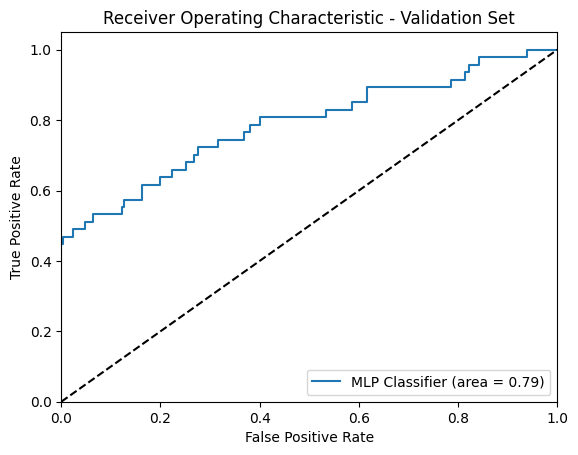

In [13]:
# ROC AUC Score
roc_auc = roc_auc_score(y_val, y_val_pred_proba)
print("ROC AUC Score (Validation Set):", roc_auc)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label='MLP Classifier (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Validation Set')
plt.legend(loc="lower right")
plt.show()

We then evaluate the test set using the same methods.

In [14]:
# Evaluate on the test set
y_test_pred_proba = mlp.predict_proba(X_test)[:, 1]
y_test_pred = mlp.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nTest Accuracy:", test_accuracy)

print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_test_pred))

# ROC AUC Score for Test Set
roc_auc_test = roc_auc_score(y_test, y_test_pred_proba)
print("ROC AUC Score (Test Set):", roc_auc_test)


Test Accuracy: 0.8163265306122449

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       123
           1       0.44      0.46      0.45        24

    accuracy                           0.82       147
   macro avg       0.67      0.67      0.67       147
weighted avg       0.82      0.82      0.82       147

Confusion Matrix (Test Set):
[[109  14]
 [ 13  11]]
ROC AUC Score (Test Set): 0.7801490514905148


The baseline accuracy is also produced for comparison. Because we have a high imbalance of data (~83% 'no'), our baseline accuracy is very high.

However, because of our imbalanced dataset, the ROC AUC is a better indication of how well our model is doing. The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various classification thresholds. The area under the ROC curve represents how well the model can distinguish between classes across all possible thresholds:
* A value of 1.0 indicates perfect classification.
* A value of 0.5 indicates random guessing.

Since the ROC AUC score evaluates the model's performance across all possible thresholds, not just a single threshold (like accuracy does). This ensures a more comprehensive view of the model's ability to separate classes. Unlike accuracy, which can be skewed by the majority class, the ROC AUC score remains a solid metric because it evaluates the ranking of predictions (how well the model separates positive and negative classes) rather than absolute predictions.

In [16]:
baseline_accuracy = y_test.value_counts(normalize=True).max()
print("\nBaseline Accuracy (Guessing the majority class):", baseline_accuracy)


Baseline Accuracy (Guessing the majority class): 0.8367346938775511
